# Feature Selection (BorutaShap)

## Data importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Manually restore the alias removed in NumPy 2.0
np.NaN = np.nan
np.bool = bool
np.float = float
import scipy.stats
import scipy.stats
import numpy as np

# 1. Fix the NumPy NaN issue we saw earlier
np.NaN = np.nan

# 2. Fix the SciPy binom_test issue
# We create a wrapper that forces 'k' and 'n' to be actual Python integers
def robust_binom_test(k, n=None, p=0.5, alternative='two-sided'):
    # Force conversion to int to satisfy SciPy's strict type checking
    try:
        if isinstance(k, (list, np.ndarray)) and len(k) == 2:
            k = [int(x) for x in k]
        else:
            k = int(k)
        if n is not None:
            n = int(n)
    except:
        pass 
    
    # Use the new binomtest if binom_test is missing
    if hasattr(scipy.stats, 'binomtest'):
        return scipy.stats.binomtest(k, n, p, alternative).pvalue
    else:
        return scipy.stats.binom_test(k, n, p, alternative)

# Inject our fix into the stats module so BorutaShap finds it
scipy.stats.binom_test = robust_binom_test
# Now import BorutaShap
from BorutaShap import BorutaShap
#adversarial_validation
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

In [2]:
from pathlib import Path
# Loading: Categories come back exactly as they were
dataset = pd.read_parquet('train_dataset_final_feature_engineered.parquet')
dataset.head(3)

,fraud_bool,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,proposed_credit_limit,foreign_request,device_os,keep_alive_session,device_distinct_emails_8w,name_email_similarity_logit,...,proposed_credit_limit_binned,prev_address_months_count_binary,banking_relationship_stability,income_level,customer_age_binned,payment_type_engineered,employment_status_engineered,intended_balcon_amount_binned_engineered,bank_branch_count_8w_binned_engineered,housing_status_engineered
0,0,5,163,1,1500.0,0,linux,1,1,4.291948,...,1000+,prev_address_missing,bank_months_valid_has_other_cards_invalid,<0.8,<=40 (less fraud),AA,CB,52+,<=42,0.006041
1,0,18,154,1,1500.0,0,other,1,1,0.478637,...,1000+,prev_address_missing,bank_months_valid_has_other_cards_invalid,0.8,<=40 (less fraud),Other,CA,Missing/Negative,<=42,0.005918
2,0,11,89,1,200.0,0,windows,0,1,5.712664,...,<=200,prev_address_valid,bank_months_valid_has_other_cards_invalid,0.8,<=40 (less fraud),Other,CA,Missing/Negative,<=42,0.005977


In [3]:
dataset.dtypes

fraud_bool                                     int64
date_of_birth_distinct_emails_4w               int64
credit_risk_score                              int64
email_is_free                                  int64
proposed_credit_limit                        float64
foreign_request                                int64
device_os                                   category
keep_alive_session                             int64
device_distinct_emails_8w                      int64
name_email_similarity_logit                  float64
days_since_request_binned                   category
valid_transferred_amount                    category
phone_home_and_mobile_valid                 category
proposed_credit_limit_binned                category
prev_address_months_count_binary            category
banking_relationship_stability              category
income_level                                category
customer_age_binned                         category
payment_type_engineered                     ca

## Feature Selection using BorutaShap

The feature selection approach will be applied to the entire train dataset since we care about comminucating the most influential features to our stakeholders and due to our deployment purpose, we will need to create tests regarding the valifity of incomding future observations (the ranges of column feature, the number of unique categories per categorical, etc..), thus we are not interested in utilising within each cross-validation fold to re-apply every time this process. 

In [4]:
dataset.iloc[:,1:]

,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,proposed_credit_limit,foreign_request,device_os,keep_alive_session,device_distinct_emails_8w,name_email_similarity_logit,days_since_request_binned,...,proposed_credit_limit_binned,prev_address_months_count_binary,banking_relationship_stability,income_level,customer_age_binned,payment_type_engineered,employment_status_engineered,intended_balcon_amount_binned_engineered,bank_branch_count_8w_binned_engineered,housing_status_engineered
0,5,163,1,1500.0,0,linux,1,1,4.291948,Immediate,...,1000+,prev_address_missing,bank_months_valid_has_other_cards_invalid,<0.8,<=40 (less fraud),AA,CB,52+,<=42,0.006041
1,18,154,1,1500.0,0,other,1,1,0.478637,Immediate,...,1000+,prev_address_missing,bank_months_valid_has_other_cards_invalid,0.8,<=40 (less fraud),Other,CA,Missing/Negative,<=42,0.005918
2,11,89,1,200.0,0,windows,0,1,5.712664,Immediate,...,<=200,prev_address_valid,bank_months_valid_has_other_cards_invalid,0.8,<=40 (less fraud),Other,CA,Missing/Negative,<=42,0.005977
3,13,90,1,200.0,0,linux,1,1,-0.099683,Immediate,...,<=200,prev_address_valid,bank_months_valid_has_other_cards_invalid,<0.8,<=40 (less fraud),Other,CA,Missing/Negative,<=42,0.006041
4,6,91,0,200.0,0,other,0,1,1.675493,Standard,...,<=200,prev_address_missing,bank_months_valid_has_other_cards_invalid,0.8,<=40 (less fraud),AA,CA,0-52,<=42,0.005977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794984,8,247,1,200.0,0,windows,0,1,0.708449,Immediate,...,<=200,prev_address_missing,bank_months_valid_has_other_cards_invalid,0.8,<=40 (less fraud),Other,CA,Missing/Negative,<=42,0.003214
794985,19,176,1,1000.0,0,windows,1,1,-0.534688,Immediate,...,200<x<=1000,prev_address_valid,bank_months_valid_has_other_cards_invalid,<0.8,<=40 (less fraud),Other,CD_CE_CF_CG,Missing/Negative,<=42,0.005855
794986,15,30,1,200.0,0,windows,0,1,-1.124198,Immediate,...,<=200,prev_address_missing,bank_months_valid_has_other_cards_invalid,<0.8,<=40 (less fraud),Other,CD_CE_CF_CG,Missing/Negative,<=42,0.005977
794987,10,42,1,200.0,0,windows,0,1,0.635182,Immediate,...,<=200,prev_address_missing,bank_months_missing_has_other_cards_invalid,<0.8,<=40 (less fraud),AC,CA,Missing/Negative,<=42,0.003090


In [5]:
# X is the entire dataframe without first column, while first column is y
X,y=dataset.iloc[:,1:], dataset.iloc[:,0]
# Check for nan values in X
print(X.isna().sum())
print(y.isna().sum())

date_of_birth_distinct_emails_4w            0
credit_risk_score                           0
email_is_free                               0
proposed_credit_limit                       0
foreign_request                             0
device_os                                   0
keep_alive_session                          0
device_distinct_emails_8w                   0
name_email_similarity_logit                 0
days_since_request_binned                   0
valid_transferred_amount                    0
phone_home_and_mobile_valid                 0
proposed_credit_limit_binned                0
prev_address_months_count_binary            0
banking_relationship_stability              0
income_level                                0
customer_age_binned                         0
payment_type_engineered                     0
employment_status_engineered                0
intended_balcon_amount_binned_engineered    0
bank_branch_count_8w_binned_engineered      0
housing_status_engineered         

Instead of random sampling used from BorutaShap (sample parameter), for feature selection on 800k rows, we do not need the whole dataset. A good rule of thumb for Boruta is to have enough data to represent the variance without hitting diminishing returns. Let's Keep all 8,000 fraud cases. Sample 32000 non-fraud cases (a 1:4 ratio).

In [6]:
# 1. Separate the classes
fraud = dataset[dataset.iloc[:, 0] == 1]
non_fraud = dataset[dataset.iloc[:, 0] == 0]

# 2. Sample non-fraud cases (e.g., 4x the number of fraud cases)
non_fraud_sample = non_fraud.sample(n=len(fraud) * 6, random_state=0)

# 3. Combine and shuffle
balanced_subset = pd.concat([fraud, non_fraud_sample]).sample(frac=1, random_state=0)

# 4. Define X and y from the subset
X_sub = balanced_subset.iloc[:, 1:]
y_sub = balanced_subset.iloc[:, 0]



Before applying feature selection method, I need to create a ML model handling efficiently categorical columns and it is accurate enough in terms of trade-off between bias and variance. In terms of simplicity, I fit a XGBoost Classifier using the default values of hyper-parameters since such model will not be used for detailed model evaluation and hence, not interested yet to waste too much time on hyper-parameter tuning since caring more about inference of influential features.

In [7]:
xgb_fi = xgb.XGBClassifier(
    n_estimators = 1000,# instead of 1500 since For Boruta trials, we only need enough trees to get a stable importance ranking. 500 trees is usually plenty for feature selection and will run 3x faster.  
    max_depth = 3,  
    learning_rate = 0.05,  
    subsample = 0.7,  
    colsample_bytree = 0.5,  
    min_child_weight = 5,  
    reg_alpha = 0.5,  
    reg_lambda = 2,  
    tree_method = 'hist',        # Use 'hist' for both CPU/GPU categorical support
    device = 'cuda',             # This replaces the old gpu_hist/predictor logic
    enable_categorical = True,   # This allows XGB to use your 'category' dtypes
    random_state = 0,
    scale_pos_weight = 6,        # # Since the ratio is 1:6, we set scale_pos_weight to 6
    eval_metric = 'aucpr'       # <--- Focuses on Precision-Recall to better handle class imbalance
)

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.datasets import load_breast_cancer, load_diabetes
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from scipy.sparse import issparse
from scipy.stats import binom_test, ks_2samp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import pandas as pd
import numpy as np
from numpy.random import choice
import seaborn as sns
import shap
import os
import re

import warnings
warnings.filterwarnings("ignore")


class BorutaShap:

    """
    BorutaShap is a wrapper feature selection method built on the foundations of both the SHAP and Boruta algorithms.

    """

    def __init__(self, model=None, importance_measure='Shap',
                classification=True, percentile=100, pvalue=0.05):

        """
        Parameters
        ----------
        model: Model Object
            If no model specified then a base Random Forest will be returned otherwise the specifed model will
            be returned.

        importance_measure: String
            Which importance measure too use either Shap or Gini/Gain

        classification: Boolean
            if true then the problem is either a binary or multiclass problem otherwise if false then it is regression

        percentile: Int
            An integer ranging from 0-100 it changes the value of the max shadow importance values. Thus, lowering its value
            would make the algorithm more lenient.

        p_value: float
            A float used as a significance level again if the p-value is increased the algorithm will be more lenient making it smaller
            would make it more strict also by making the model more strict could impact runtime making it slower. As it will be less likley
            to reject and accept features.

        """

        self.importance_measure = importance_measure
        self.percentile = percentile
        self.pvalue = pvalue
        self.classification = classification
        self.model = model
        self.check_model()

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator"""
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, "deprecated_original", cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = inspect.signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [
            p
            for p in init_signature.parameters.values()
            if p.name != "self" and p.kind != p.VAR_KEYWORD
        ]
        for p in parameters:
            if p.kind == p.VAR_POSITIONAL:
                raise RuntimeError(
                    "scikit-learn estimators should always "
                    "specify their parameters in the signature"
                    " of their __init__ (no varargs)."
                    " %s with constructor %s doesn't "
                    " follow this convention." % (cls, init_signature)
                )
        # Extract and sort argument names excluding 'self'
        return sorted([p.name for p in parameters])

    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : dict
            Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params") and not isinstance(value, type):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def set_params(self, **params):
        """Set the parameters of this estimator.
        The method works on simple estimators as well as on nested objects
        (such as :class:`~sklearn.pipeline.Pipeline`). The latter have
        parameters of the form ``<component>__<parameter>`` so that it's
        possible to update each component of a nested object.
        Parameters
        ----------
        **params : dict
            Estimator parameters.
        Returns
        -------
        self : estimator instance
            Estimator instance.
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                local_valid_params = self._get_param_names()
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {local_valid_params!r}."
                )

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return 


    def check_model(self):

        """
        Checks that a model object has been passed as a parameter when intiializing the BorutaShap class.

        Returns
        -------
        Model Object
            If no model specified then a base Random Forest will be returned otherwise the specifed model will
            be returned.

        Raises
        ------
        AttirbuteError
             If the model object does not have the required attributes.

        """

        check_fit = hasattr(self.model, 'fit')
        check_predict_proba = hasattr(self.model, 'predict')

        try:
            check_feature_importance = hasattr(self.model, 'feature_importances_')

        except:
            check_feature_importance = True


        if self.model is None:

            if self.classification:
                self.model = RandomForestClassifier()
            else:
                self.model = RandomForestRegressor()

        elif check_fit is False and check_predict_proba is False:
            raise AttributeError('Model must contain both the fit() and predict() methods')

        elif check_feature_importance is False and self.importance_measure == 'gini':
            raise AttributeError('Model must contain the feature_importances_ method to use Gini try Shap instead')

        else:
            pass


    def check_X(self):

        """
        Checks that the data passed to the BorutaShap instance is a pandas Dataframe

        Returns
        -------
        Datframe

        Raises
        ------
        AttirbuteError
             If the data is not of the expected type.

        """

        if isinstance(self.X, pd.DataFrame) is False:
            raise AttributeError('X must be a pandas Dataframe')

        else:
            pass


    def missing_values_y(self):

        """
        Checks for missing values in target variable.

        Returns
        -------
        Boolean

        Raises
        ------
        AttirbuteError
             If data is not in the expected format.

        """

        if isinstance(self.y, pd.Series) or isinstance(self.y, pd.DataFrame):
            return self.y.isnull().any().any()

        elif isinstance(self.y, np.ndarray):
            return np.isnan(self.y).any()

        else:
            raise AttributeError('Y must be a pandas Dataframe, Series, or a numpy array')


    def check_missing_values(self):

        """
        Checks for missing values in the data.

        Returns
        -------
        Boolean

        Raises
        ------
        AttirbuteError
             If there are missing values present.

        """

        X_missing = self.X.isnull().any().any()
        Y_missing = self.missing_values_y()

        models_to_check = ('xgb', 'catboost', 'lgbm', 'lightgbm')

        model_name = str(type(self.model)).lower()
        if X_missing or Y_missing:

            if any([x in model_name for x in models_to_check]):
                print('Warning there are missing values in your data !')

            else:
                raise ValueError('There are missing values in your Data')

        else:
            pass


    def Check_if_chose_train_or_test_and_train_model(self):

        """
        Decides to fit the model to either the training data or the test/unseen data a great discussion on the
        differences can be found here.

        https://slds-lmu.github.io/iml_methods_limitations/pfi-data.html

        """
        if self.stratify is not None and not self.classification:
            raise ValueError('Cannot take a strtified sample from continuous variable please bucket the variable and try again !')


        if self.train_or_test.lower() == 'test':
            # keeping the same naming convenetion as to not add complexit later on
            self.X_boruta_train, self.X_boruta_test, self.y_train, self.y_test, self.w_train, self.w_test = train_test_split(self.X_boruta,
                                                                                                                                self.y,
                                                                                                                                self.sample_weight,
                                                                                                                                test_size=0.3,
                                                                                                                                random_state=self.random_state,
                                                                                                                                stratify=self.stratify)
            self.Train_model(self.X_boruta_train, self.y_train, sample_weight = self.w_train)

        elif self.train_or_test.lower() == 'train':
            # model will be trained and evaluated on the same data
            self.Train_model(self.X_boruta, self.y, sample_weight = self.sample_weight)

        else:
            raise ValueError('The train_or_test parameter can only be "train" or "test"')



    def Train_model(self, X, y, sample_weight = None):

        """
        Trains Model also checks to see if the model is an instance of catboost as it needs extra parameters
        also the try except is for models with a verbose statement

        Parameters
        ----------
        X: Dataframe
            A pandas dataframe of the features.

        y: Series/ndarray
            A pandas series or numpy ndarray of the target

        sample_weight: Series/ndarray
            A pandas series or numpy ndarray of the sample weights

        Returns
        ----------
        fitted model object

        """

        if 'catboost' in str(type(self.model)).lower():
            self.model.fit(X, y, sample_weight = sample_weight, cat_features = self.X_categorical,  verbose=False)

        else:

            try:
                self.model.fit(X, y, sample_weight = sample_weight, verbose=False)

            except:
                self.model.fit(X, y, sample_weight = sample_weight)




    def fit(self, X, y, sample_weight = None, n_trials = 20, random_state=0, sample=False,
            train_or_test = 'test', normalize=True, verbose=True, stratify=None):

        """
        The main body of the program this method it computes the following

        1. Extend the information system by adding copies of all variables (the information system
        is always extended by at least 5 shadow attributes, even if the number of attributes in
        the original set is lower than 5).

        2. Shuffle the added attributes to remove their correlations with the response.

        3. Run a random forest classifier on the extended information system and gather the
        Z scores computed.

        4. Find the maximum Z score among shadow attributes (MZSA), and then assign a hit to
        every attribute that scored better than MZSA.

        5. For each attribute with undetermined importance perform a two-sided test of equality
        with the MZSA.

        6. Deem the attributes which have importance significantly lower than MZSA as ‘unimportant’
        and permanently remove them from the information system.

        7. Deem the attributes which have importance significantly higher than MZSA as ‘important’.

        8. Remove all shadow attributes.

        9. Repeat the procedure until the importance is assigned for all the attributes, or the
        algorithm has reached the previously set limit of the random forest runs.

        10. Stores results.

        Parameters
        ----------
        X: Dataframe
            A pandas dataframe of the features.

        y: Series/ndarray
            A pandas series or numpy ndarray of the target

        sample_weight: Series/ndarray
            A pandas series or numpy ndarray of the sample weight of the observations (optional)

        random_state: int
            A random state for reproducibility of results

        Sample: Boolean
            if true then a rowise sample of the data will be used to calculate the feature importance values

        sample_fraction: float
            The sample fraction of the original data used in calculating the feature importance values only
            used if Sample==True.

        train_or_test: string
            Decides whether the feature importance should be calculated on out of sample data see the dicussion here.
            https://compstat-lmu.github.io/iml_methods_limitations/pfi-data.html#introduction-to-test-vs.training-data

        normalize: boolean
            if true the importance values will be normalized using the z-score formula

        verbose: Boolean
            a flag indicator to print out all the rejected or accepted features.

        stratify: array
            allows the train test splits to be stratified based on given values.

        """

        if sample_weight is None:
            sample_weight = np.ones(len(X))
        np.random.seed(random_state)
        self.starting_X = X.copy()
        self.X = X.copy()
        self.y = y.copy()
        self.sample_weight = sample_weight.copy()
        self.n_trials = n_trials
        self.random_state = random_state
        self.ncols = self.X.shape[1]
        self.all_columns = self.X.columns.to_numpy()
        self.rejected_columns = []
        self.accepted_columns = []

        self.check_X()
        self.check_missing_values()
        self.sample = sample
        self.train_or_test = train_or_test
        self.stratify = stratify

        self.features_to_remove = []
        self.hits  = np.zeros(self.ncols)
        self.order = self.create_mapping_between_cols_and_indices()
        self.create_importance_history()

        if self.sample: self.preds = self.isolation_forest(self.X, self.sample_weight)

        for trial in tqdm(range(self.n_trials)):

            self.remove_features_if_rejected()
            self.columns = self.X.columns.to_numpy()
            self.create_shadow_features()

            # early stopping
            if self.X.shape[1] == 0:
                break

            else:

                self.Check_if_chose_train_or_test_and_train_model()

                self.X_feature_import, self.Shadow_feature_import = self.feature_importance(normalize=normalize)
                self.update_importance_history()
                hits = self.calculate_hits()
                self.hits += hits
                self.history_hits = np.vstack((self.history_hits, self.hits))
                self.test_features(iteration=trial+1)

        self.store_feature_importance()
        self.calculate_rejected_accepted_tentative(verbose=verbose)

    def transform(self, X):
        return self.Subset(self)
        
    def calculate_rejected_accepted_tentative(self, verbose):

        """
        Figures out which features have been either accepted rejeected or tentative

        Returns
        -------
        3 lists

        """

        self.rejected  = list(set(self.flatten_list(self.rejected_columns))-set(self.flatten_list(self.accepted_columns)))
        self.accepted  = list(set(self.flatten_list(self.accepted_columns)))
        self.tentative = list(set(self.all_columns) - set(self.rejected + self.accepted))

        if verbose:
            print(str(len(self.accepted))  + ' attributes confirmed important: ' + str(self.accepted))
            print(str(len(self.rejected))  + ' attributes confirmed unimportant: ' + str(self.rejected))
            print(str(len(self.tentative)) + ' tentative attributes remains: ' + str(self.tentative))



    def create_importance_history(self):

        """
        Creates a dataframe object to store historical feature importance scores.

        Returns
        -------
        Datframe

        """

        self.history_shadow = np.zeros(self.ncols)
        self.history_x = np.zeros(self.ncols)
        self.history_hits = np.zeros(self.ncols)


    def update_importance_history(self):

        """
        At each iteration update the datframe object that stores the historical feature importance scores.

        Returns
        -------
        Datframe

        """

        padded_history_shadow  = np.full((self.ncols), np.NaN)
        padded_history_x = np.full((self.ncols), np.NaN)

        for (index, col) in enumerate(self.columns):
            map_index = self.order[col]
            padded_history_shadow[map_index] = self.Shadow_feature_import[index]
            padded_history_x[map_index] = self.X_feature_import[index]

        self.history_shadow = np.vstack((self.history_shadow, padded_history_shadow))
        self.history_x = np.vstack((self.history_x, padded_history_x))



    def store_feature_importance(self):

        """
        Reshapes the columns in the historical feature importance scores object also adds the mean, median, max, min
        shadow feature scores.

        Returns
        -------
        Datframe

        """

        self.history_x = pd.DataFrame(data=self.history_x,
                                 columns=self.all_columns)


        self.history_x['Max_Shadow']    =  [max(i) for i in self.history_shadow]
        self.history_x['Min_Shadow']    =  [min(i) for i in self.history_shadow]
        self.history_x['Mean_Shadow']   =  [np.nanmean(i) for i in self.history_shadow]
        self.history_x['Median_Shadow'] =  [np.nanmedian(i) for i in self.history_shadow]


    def results_to_csv(self, filename='feature_importance'):

        """
        Saves the historical feature importance scores to csv.

        Parameters
        ----------
        filname : string
            used as the name for the outputed file.

        Returns
        -------
        comma delimnated file

        """

        features = pd.DataFrame(data={'Features':self.history_x.iloc[1:].columns.values,
        'Average Feature Importance':self.history_x.iloc[1:].mean(axis=0).values,
        'Standard Deviation Importance':self.history_x.iloc[1:].std(axis=0).values})

        decision_mapper = self.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
        features['Decision'] = features['Features'].map(decision_mapper)
        features = features.sort_values(by='Average Feature Importance',ascending=False)

        features.to_csv(filename + '.csv', index=False)


    def remove_features_if_rejected(self):

        """
        At each iteration if a feature has been rejected by the algorithm remove it from the process

        """

        if len(self.features_to_remove) != 0:
            for feature in self.features_to_remove:
                try:
                    self.X.drop(feature, axis = 1, inplace=True)
                except:
                    pass

        else:
            pass


    @staticmethod
    def average_of_list(lst):
        return sum(lst) / len(lst)

    @staticmethod
    def flatten_list(array):
        return [item for sublist in array for item in sublist]


    def create_mapping_between_cols_and_indices(self):
        return dict(zip(self.X.columns.to_list(), np.arange(self.X.shape[1])))


    def calculate_hits(self):

        """
        If a features importance is greater than the maximum importance value of all the random shadow
        features then we assign it a hit.

        Parameters
        ----------
        Percentile : value ranging from 0-1
            can be used to reduce value of the maximum value of the shadow features making the algorithm
            more lenient.

        """

        shadow_threshold = np.percentile(self.Shadow_feature_import,
                                        self.percentile)

        padded_hits = np.zeros(self.ncols)
        hits = self.X_feature_import > shadow_threshold

        for (index, col) in enumerate(self.columns):
            map_index = self.order[col]
            padded_hits[map_index] += hits[index]

        return padded_hits


    def create_shadow_features(self):
        """
        Creates the random shadow features by shuffling the existing columns.

        Returns:
            Datframe with random permutations of the original columns.
        """
        self.X_shadow = self.X.apply(np.random.permutation)
        
        if isinstance(self.X_shadow, pd.DataFrame):
            # append
            obj_col = self.X_shadow.select_dtypes("object").columns.tolist()
            if obj_col ==[] :
                 pass
            else :
                 self.X_shadow[obj_col] =self.X_shadow[obj_col].astype("category")

        self.X_shadow.columns = ['shadow_' + feature for feature in self.X.columns]
        self.X_boruta = pd.concat([self.X, self.X_shadow], axis = 1)

        col_types = self.X_boruta.dtypes
        self.X_categorical = list(col_types[(col_types=='category' ) | (col_types=='object')].index)


    @staticmethod
    def calculate_Zscore(array):
        """
        Calculates the Z-score of an array

        Parameters
         ----------
        array: array_like

        Returns:
            normalised array
        """
        mean_value = np.mean(array)
        std_value  = np.std(array)
        return [(element-mean_value)/std_value for element in array]


    def feature_importance(self, normalize):

        """
        Caculates the feature importances scores of the model

        Parameters
        ----------
        importance_measure: string
            allows the user to choose either the Shap or Gini importance metrics

        normalize: boolean
            if true the importance values will be normalized using the z-score formula

        Returns:
            array of normalized feature importance scores for both the shadow and original features.

        Raise
        ----------
            ValueError:
                If no Importance measure was specified
        """

        if self.importance_measure == 'shap':

            self.explain()
            vals = self.shap_values

            if normalize:
                vals = self.calculate_Zscore(vals)

            X_feature_import = vals[:len(self.X.columns)]
            Shadow_feature_import = vals[len(self.X_shadow.columns):]
            
        elif self.importance_measure == 'perm':
            
            # set default scoring as f1, can be changed to an argument for customizability
            perm_importances_ =  permutation_importance(self.model, self.X, self.y, scoring='f1')
            perm_importances_ = perm_importance.importances_mean

            if normalize:
                perm_importances_ = self.calculate_Zscore(perm_importances_)

            X_feature_import = perm_importances_[:len(self.X.columns)]
            Shadow_feature_import = perm_importances_[len(self.X.columns):]

        elif self.importance_measure == 'gini':

                feature_importances_ =  np.abs(self.model.feature_importances_)

                if normalize:
                    feature_importances_ = self.calculate_Zscore(feature_importances_)

                X_feature_import = feature_importances_[:len(self.X.columns)]
                Shadow_feature_import = feature_importances_[len(self.X.columns):]

        else:

            raise ValueError('No Importance_measure was specified select one of (shap, perm, gini)')


        return X_feature_import, Shadow_feature_import


    @staticmethod
    def isolation_forest(X, sample_weight):
        '''
        fits isloation forest to the dataset and gives an anomally score to every sample
        '''
        clf = IsolationForest().fit(X, sample_weight = sample_weight)
        preds = clf.score_samples(X)
        return preds


    @staticmethod
    def get_5_percent(num):
        return round(5  / 100 * num)


    def get_5_percent_splits(self, length):
        '''
        splits dataframe into 5% intervals
        '''
        five_percent = self.get_5_percent(length)
        return np.arange(five_percent,length,five_percent)



    def find_sample(self):
        '''
        Finds a sample by comparing the distributions of the anomally scores between the sample and the original
        distribution using the KS-test. Starts of a 5% howver will increase to 10% and then 15% etc. if a significant sample can not be found
        '''
        loop = True
        iteration = 0
        size = self.get_5_percent_splits(self.X.shape[0])
        element = 1
        while loop:

            sample_indices = choice(np.arange(self.preds.size),  size=size[element], replace=False)
            sample = np.take(self.preds, sample_indices)
            if ks_2samp(self.preds, sample).pvalue > 0.95:
                break
            
            iteration+=1

            if iteration == 20:
                element  += 1
                iteration = 0


        return self.X_boruta.iloc[sample_indices]



    def explain(self):

        """
        The shap package has numerous variants of explainers which use different assumptions depending on the model
        type this function allows the user to choose explainer

        Returns:
            shap values

        Raise
        ----------
            ValueError:
                if no model type has been specified tree as default
        """


        explainer = shap.TreeExplainer(self.model, 
                                       feature_perturbation = "tree_path_dependent",
                                       approximate = True)


        if self.sample:


            if self.classification:
                # for some reason shap returns values wraped in a list of length 1

                self.shap_values = np.array(explainer.shap_values(self.find_sample()))
                if isinstance(self.shap_values, list):

                    class_inds = range(len(self.shap_values))
                    shap_imp = np.zeros(self.shap_values[0].shape[1])
                    for i, ind in enumerate(class_inds):
                        shap_imp += np.abs(self.shap_values[ind]).mean(0)
                    self.shap_values /= len(self.shap_values)

                elif len(self.shap_values.shape) == 3:
                    self.shap_values = np.abs(self.shap_values).sum(axis=0)
                    self.shap_values = self.shap_values.mean(0)

                else:
                    self.shap_values = np.abs(self.shap_values).mean(0)

            else:
                self.shap_values = explainer.shap_values(self.find_sample())
                self.shap_values = np.abs(self.shap_values).mean(0)

        else:

            if self.classification:
                # for some reason shap returns values wraped in a list of length 1
                self.shap_values = np.array(explainer.shap_values(self.X_boruta))
                if isinstance(self.shap_values, list):

                    class_inds = range(len(self.shap_values))
                    shap_imp = np.zeros(self.shap_values[0].shape[1])
                    for i, ind in enumerate(class_inds):
                        shap_imp += np.abs(self.shap_values[ind]).mean(0)
                    self.shap_values /= len(self.shap_values)

                elif len(self.shap_values.shape) == 3:
                    self.shap_values = np.abs(self.shap_values).sum(axis=0)
                    self.shap_values = self.shap_values.mean(0)

                else:
                    self.shap_values = np.abs(self.shap_values).mean(0)

            else:
                self.shap_values = explainer.shap_values(self.X_boruta)
                self.shap_values = np.abs(self.shap_values).mean(0)



    @staticmethod
    def binomial_H0_test(array, n, p, alternative):
        """
        Perform a test that the probability of success is p.
        This is an exact, two-sided test of the null hypothesis
        that the probability of success in a Bernoulli experiment is p
        """
        return [binom_test(x, n=n, p=p, alternative=alternative) for x in array]


    @staticmethod
    def symetric_difference_between_two_arrays(array_one, array_two):
        set_one = set(array_one)
        set_two = set(array_two)
        return np.array(list(set_one.symmetric_difference(set_two)))


    @staticmethod
    def find_index_of_true_in_array(array):
        length = len(array)
        return list(filter(lambda x: array[x], range(length)))


    @staticmethod
    def bonferoni_corrections(pvals, alpha=0.05, n_tests=None):
        """
        used to counteract the problem of multiple comparisons.
        """
        pvals = np.array(pvals)

        if n_tests is None:
            n_tests = len(pvals)
        else:
            pass

        alphacBon = alpha / float(n_tests)
        reject = pvals <= alphacBon
        pvals_corrected = pvals * float(n_tests)
        return reject, pvals_corrected


    def test_features(self, iteration):

        """
        For each feature with an undetermined importance perform a two-sided test of equality
        with the maximum shadow value to determine if it is statistcally better

        Parameters
        ----------
        hits: an array which holds the history of the number times
              this feature was better than the maximum shadow

        Returns:
            Two arrays of the names of the accepted and rejected columns at that instance
        """

        acceptance_p_values = self.binomial_H0_test(self.hits,
                                                    n=iteration,
                                                    p=0.5,
                                                    alternative='greater')

        regect_p_values = self.binomial_H0_test(self.hits,
                                                n=iteration,
                                                p=0.5,
                                                alternative='less')

        # [1] as function returns a tuple
        modified_acceptance_p_values = self.bonferoni_corrections(acceptance_p_values,
                                                                  alpha=0.05,
                                                                  n_tests=len(self.columns))[1]

        modified_regect_p_values = self.bonferoni_corrections(regect_p_values,
                                                              alpha=0.05,
                                                              n_tests=len(self.columns))[1]

        # Take the inverse as we want true to keep featrues
        rejected_columns = np.array(modified_regect_p_values) < self.pvalue
        accepted_columns = np.array(modified_acceptance_p_values) < self.pvalue

        rejected_indices = self.find_index_of_true_in_array(rejected_columns)
        accepted_indices = self.find_index_of_true_in_array(accepted_columns)

        rejected_features = self.all_columns[rejected_indices]
        accepted_features = self.all_columns[accepted_indices]


        self.features_to_remove = rejected_features


        self.rejected_columns.append(rejected_features)
        self.accepted_columns.append(accepted_features)


    def TentativeRoughFix(self):

        """
        Sometimes no matter how many iterations are run a feature may neither be rejected or
        accepted. This method is used in this case to make a decision on a tentative feature
        by comparing its median importance value with the median max shadow value.

        Parameters
        ----------
        tentative: an array which holds the names of the tentative attiributes.

        Returns:
            Two arrays of the names of the final decision of the accepted and rejected columns.

        """

        median_tentaive_values = self.history_x[self.tentative].median(axis=0).values
        median_max_shadow = self.history_x['Max_Shadow'].median(axis=0)


        filtered = median_tentaive_values > median_max_shadow

        self.tentative = np.array(self.tentative)
        newly_accepted = self.tentative[filtered]

        if len(newly_accepted) < 1:
            newly_rejected = self.tentative

        else:
            newly_rejected = self.symetric_difference_between_two_arrays(newly_accepted, self.tentative)

        print(str(len(newly_accepted)) + ' tentative features are now accepted: ' + str(newly_accepted))
        print(str(len(newly_rejected)) + ' tentative features are now rejected: ' + str(newly_rejected))

        self.rejected = self.rejected + newly_rejected.tolist()
        self.accepted = self.accepted + newly_accepted.tolist()



    def Subset(self, tentative=False):
        """
        Returns the subset of desired features
        """
        if tentative:
            return self.starting_X[self.accepted + list(self.tentative)]
        else:
            return self.starting_X[self.accepted]


    @staticmethod
    def create_list(array, color):
        colors = [color for x in range(len(array))]
        return colors

    @staticmethod
    def filter_data(data, column, value):
        data = data.copy()
        return data.loc[(data[column] == value) | (data[column] == 'Shadow')]


    @staticmethod
    def hasNumbers(inputString):
        return any(char.isdigit() for char in inputString)


    @staticmethod
    def check_if_which_features_is_correct(my_string):

        my_string = str(my_string).lower()
        if my_string in ['tentative','rejected','accepted','all']:
            pass

        else:
            raise ValueError(my_string + " is not a valid value did you mean to type 'all', 'tentative', 'accepted' or 'rejected' ?")



    def plot(self, X_rotation=90, X_size=8, figsize=(12,8),
            y_scale='log', which_features='all', display=True):

        """
        creates a boxplot of the feature importances

        Parameters
        ----------
        X_rotation: int
            Controls the orientation angle of the tick labels on the X-axis

        X_size: int
            Controls the font size of the tick labels

        y_scale: string
            Log transform of the y axis scale as hard to see the plot as it is normally dominated by two or three
            features.

        which_features: string
            Despite efforts if the number of columns is large the plot becomes cluttered so this parameter allows you to
            select subsets of the features like the accepted, rejected or tentative features default is all.

        Display: Boolean
        controls if the output is displayed or not, set to false when running test scripts

        """
        # data from wide to long
        data = self.history_x.iloc[1:]
        data['index'] = data.index
        data = pd.melt(data, id_vars='index', var_name='Methods')

        decision_mapper = self.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
        data['Decision'] = data['Methods'].map(decision_mapper)
        data.drop(['index'], axis=1, inplace=True)


        options = { 'accepted' : self.filter_data(data,'Decision', 'Accepted'),
                    'tentative': self.filter_data(data,'Decision', 'Tentative'),
                    'rejected' : self.filter_data(data,'Decision', 'Rejected'),
                    'all' : data
                    }

        self.check_if_which_features_is_correct(which_features)
        data = options[which_features.lower()]

        self.box_plot(data=data,
                      X_rotation=X_rotation,
                      X_size=X_size,
                      y_scale=y_scale,
                      figsize=figsize)
        if display:
            plt.show()
        else:
            plt.close()


    def box_plot(self, data, X_rotation, X_size, y_scale, figsize):

        if y_scale=='log':
            minimum = data['value'].min()
            if minimum <= 0:
                data['value'] += abs(minimum) + 0.01

        order = data.groupby(by=["Methods"])["value"].mean().sort_values(ascending=False).index
        my_palette = self.create_mapping_of_features_to_attribute(maps= ['yellow','red','green','blue'])

        # Use a color palette
        plt.figure(figsize=figsize)
        ax = sns.boxplot(x=data["Methods"], y=data["value"],
                        order=order, palette=my_palette)

        if y_scale == 'log':ax.set(yscale="log")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=X_rotation, size=X_size)
        ax.set_title('Feature Importance')
        ax.set_ylabel('Z-Score')
        ax.set_xlabel('Features')


    def create_mapping_of_features_to_attribute(self, maps = []):

        rejected = list(self.rejected)
        tentative = list(self.tentative)
        accepted = list(self.accepted)
        shadow = ['Max_Shadow','Median_Shadow','Min_Shadow','Mean_Shadow']

        tentative_map = self.create_list(tentative, maps[0])
        rejected_map  = self.create_list(rejected, maps[1])
        accepted_map  = self.create_list(accepted, maps[2])
        shadow_map = self.create_list(shadow, maps[3])

        values = tentative_map + rejected_map + accepted_map + shadow_map
        keys = tentative + rejected + accepted + shadow

        return self.to_dictionary(keys, values)


    @staticmethod
    def to_dictionary(list_one, list_two):
        return dict(zip(list_one, list_two))


In [9]:
X.shape
dataset["fraud_bool"].value_counts(normalize=True)

fraud_bool
0    0.989747
1    0.010253
Name: proportion, dtype: float64

In [10]:
# no model selected default is Random Forest, if classification is True it is a Classification problem
Feature_Selector = BorutaShap(model=xgb_fi, importance_measure='shap',
                              classification=True)

'''
Sample: Boolean
	if true then a rowise sample of the data will be used to calculate the feature importance values

sample_fraction: float
	The sample fraction of the original data used in calculating the feature importance values only
        used if Sample==True.

train_or_test: string
	Decides whether the feature improtance should be calculated on out of sample data see the dicussion here.
        https://slds-lmu.github.io/iml_methods_limitations/pfi-data.html

normalize: boolean
            if true the importance values will be normalized using the z-score formula

verbose: Boolean
	a flag indicator to print out all the rejected or accepted features.
Interesting page about SHAP values is https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137/
 
'''
Feature_Selector.fit(X=X_sub, y=y_sub, n_trials=90, sample=False,normalize=True)# Boruta usually stabilizes after 40-50 trials.

  0%|          | 0/90 [00:00<?, ?it/s]

16 attributes confirmed important: ['device_distinct_emails_8w', 'payment_type_engineered', 'date_of_birth_distinct_emails_4w', 'name_email_similarity_logit', 'intended_balcon_amount_binned_engineered', 'income_level', 'customer_age_binned', 'employment_status_engineered', 'keep_alive_session', 'phone_home_and_mobile_valid', 'banking_relationship_stability', 'prev_address_months_count_binary', 'device_os', 'email_is_free', 'housing_status_engineered', 'credit_risk_score']
6 attributes confirmed unimportant: ['proposed_credit_limit', 'valid_transferred_amount', 'proposed_credit_limit_binned', 'foreign_request', 'days_since_request_binned', 'bank_branch_count_8w_binned_engineered']
0 tentative attributes remains: []


Check the features importance through SHAP values

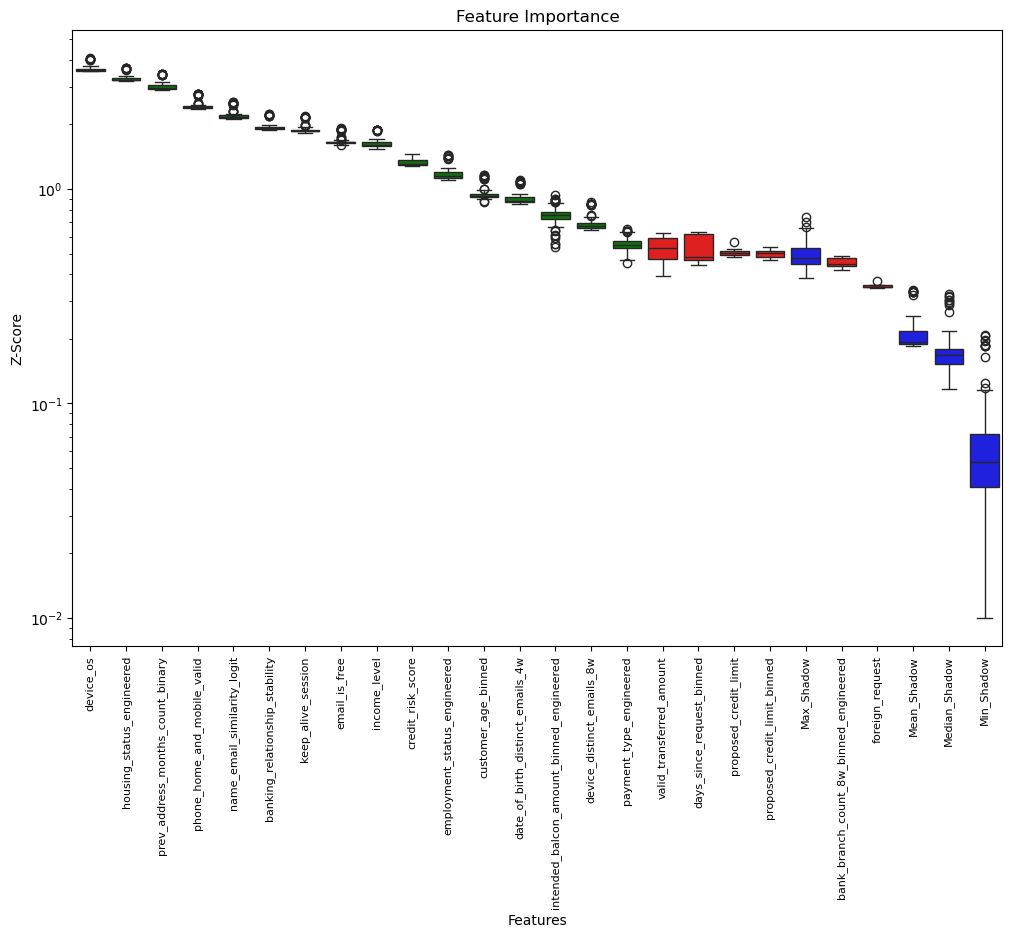

In [11]:
# Returns Boxplot of features
Feature_Selector.plot(which_features='all')